In [1]:
# IMAGE CONFIGURATIONS
IMAGE_SIZE = [299, 299] 

# TRAINING CONFIGURATIONS
epochs = 16
batch_size = 128

## Preparing Data

In [2]:
import pandas as pd
df_train_data = pd.read_csv("../data/merged_train.csv")
df_train_data

,image_id,labels
0,723977410.jpg,3
1,3193577634.jpg,1
2,3349107107.jpg,3
3,2933959901.jpg,0
4,3020460837.jpg,4
...,...,...
27048,1778392170.jpg,2
27049,2495608764.jpg,3
27050,698646619.jpg,4
27051,297559984.jpg,3


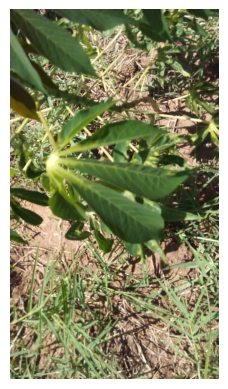

In [3]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torchvision import transforms

# Define the path to your train_images directory
train_path = "../data/train_images/"

# Use glob to get all image files with .jpg or .jpeg extensions
image_files = glob(train_path + '/*.jp*g')

# Define the transformation (ToTensor)
transform = transforms.ToTensor()

# Randomly select an image path
img_path = np.random.choice(image_files)

# Open the image
image = Image.open(img_path)

# Apply the transform to convert the image to a tensor
image_tensor = transform(image)

# Display the image
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute is needed to change the shape to (H, W, C)
plt.axis('off')  # Hide axis
plt.show()

In [4]:
unique_labels = df_train_data.labels.value_counts()
num_unique_labels = unique_labels.nunique()


In [5]:
from sklearn import model_selection
df_train, df_valid = model_selection.train_test_split(df_train_data, test_size=0.1, random_state=109, stratify=df_train_data["labels"].values)
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [6]:
from torch.utils.data import Dataset
import os 
import cv2
class ConstDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['labels'].values
        self.transform = transform  # Fixed placement of transform
        self.train_path = train_path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(self.train_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:

proc_resize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=IMAGE_SIZE)
])


train_df = ConstDataset(df_train, transform=proc_resize)



In [8]:
import torch 
trainloader = torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0)

In [9]:
from tqdm import tqdm
def calc_mean_std(train_df, trainloader): 
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])
    
    for input_image,_ in tqdm(trainloader):
        psum    += input_image.sum(axis        = [0, 2, 3])
        psum_sq += (input_image ** 2).sum(axis = [0, 2, 3])

    count = len(train_df) * IMAGE_SIZE[0] * IMAGE_SIZE[1]   
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    mean = total_mean.numpy()
    std = total_std.numpy()
    return (mean, std)
calc_mean, calc_std = calc_mean_std(train_df, trainloader)

100%|██████████| 191/191 [03:21<00:00,  1.05s/it]


In [10]:
proc_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = IMAGE_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=calc_mean,std=calc_std)
])
train_df = ConstDataset(df_train, transform=proc_aug)
valid_df = ConstDataset(df_valid, transform=proc_aug)

In [11]:
# trainloader = torch.utils.data.DataLoader(train_df, batch_size=4,
#                                           shuffle=True, num_workers=0)
# torch.manual_seed(124)
# for batch_idx, data in enumerate(trainloader,0):
#     if(batch_idx==0): 
#         input, label = data 
#         print(type(input))
#         print(input[0].shape)
#         print(input[0])
#         plt.imshow(input[0].numpy().transpose(1,2,0))
#     break;



In [12]:
dataloader = {'train': torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0), 
              'val': torch.utils.data.DataLoader(valid_df, batch_size,
                                          shuffle=True, num_workers=0)}
device = 'cpu'

## Training model

In [13]:
LEARNING_RATE = 0.001
MOMENTUM = 0.9

In [14]:
import timm
import torch.nn as nn
model = timm.create_model('tf_efficientnet_b4.ns_jft_in1k', pretrained=True)

num_classes = num_unique_labels

model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(model.num_features, num_classes)  # Adjust num_classes
)

/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [16]:
# import numpy as np
# import torch
# from sklearn.metrics import accuracy_score

# # Compute metrics function for both accuracy and loss
# def compute_metrics(p):
#     # Extract predictions (logits) and labels
#     preds = np.argmax(p.predictions, axis=1)  # Taking the argmax across logits
#     labels = p.label_ids

#     # Calculate accuracy
#     acc = accuracy_score(labels, preds)
    
#     # Return a dictionary of metrics
#     return {
#         'accuracy': acc,
#         'eval_loss': p.loss,  # Hugging Face will compute and provide this
#     }

In [17]:
# !pip install --upgrade transformers
# !pip install torch torchvision datasets
# !pip cache purge
# !pip install --upgrade transformers huggingface_hub
# !pip install --upgrade transformers huggingface_hub
#!pip install --upgrade huggingface_hub transformers
# !pip install accelerate==0.31.0
#pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [18]:

# # Hugging Face Training Arguments
# training_args = TrainingArguments(
#     output_dir='./results',          # output directory
#     num_train_epochs=3,              # total number of training epochs
#     per_device_train_batch_size=16,  # batch size for training
#     per_device_eval_batch_size=64,   # batch size for evaluation
#     warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir='./logs',            # directory for storing logs
#     logging_steps=10,
# )

# # Define Trainer with your model, optimizer, and loss function
# trainer = Trainer(
#     model=model,                      # The model to train
#     args=training_args,               # Training arguments
#     train_dataset=train_df,           # Training dataset
#     eval_dataset=valid_df,            # Evaluation dataset
#     compute_metrics=compute_metrics,  # Optional: to compute metrics
#     optimizers=(optimizer, None)      # Optimizer and scheduler (None for no scheduler)
# )

# # Train the model
# trainer.train()

In [19]:
!pip install --upgrade transformers huggingface_hub
!pip install accelerate==0.31.0


In [20]:
from transformers import Trainer, TrainingArguments
import torch.nn as nn
import torch.optim as optim

# Assuming model has been created using timm and loaded

# Unfreeze only the classifier layer
for name, param in model.named_parameters():
    if "fc" in name or "classifier" in name:  # Adjust for final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
#!pip install -U transformers
#!pip install tensorflow-macos


In [22]:
# Define device (MPS or CPU)
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
# Move the model to the selected device
model = model.to(device)

In [23]:
# # Training and Validation Loop
# for epoch in range(epochs):
#     print(f'Epoch {epoch+1}/{epochs}')
#     print('-' * 10)

#     for phase in ['train', 'val']:
#         if phase == 'train':
#             model.train()  # Set model to training mode
#         else:
#             model.eval()   # Set model to evaluation mode

#         running_loss = 0.0
#         running_corrects = 0

#         # Iterate over data.
#         for inputs, labels in trainloader:
#             #inputs, labels = inputs.to(device), labels.to(device)

#             # Zero the parameter gradients
#             optimizer.zero_grad()

#             # Forward pass
#             with torch.set_grad_enabled(phase == 'train'):
#                 outputs = model(inputs)

#                 # MODIFICATION: If outputs is a tuple, take the first element (logits)
#                 if isinstance(outputs, tuple):
#                     outputs = outputs[0]

#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)

#                 # Backward pass and optimize in the training phase
#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             # Update running loss and correct predictions
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         # Calculate epoch loss and accuracy
#         dataset_size = len(train_df) if phase == 'train' else len(valid_df)
#         epoch_loss = running_loss / dataset_size
#         epoch_acc = running_corrects.double() / dataset_size

#         print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# print("Training complete!")

In [24]:
for epoch in range(epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader[phase]:
            inputs, labels = inputs.to(device),labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            
            #MODIFICATIONS
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            with torch.set_grad_enabled(phase == 'train'):
                _, preds = torch.max(outputs, 1)
  
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        if phase == 'train': 
            epoch_loss = running_loss / len(train_df)
            epoch_acc = running_corrects.float() / len(train_df)
        else: 
            epoch_loss = running_loss / len(valid_df)
            epoch_acc = running_corrects.float() / len(valid_df)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 1792x5)

In [ ]:
# Define the path where you want to save the model
save_path = './trained_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

In [88]:
#https://pytorch.org/vision/0.9/models.html